Now that we have our hatsTrees that have the interesting physical variables calculated, let's do some analysis with them. To combine our MC background samples, we will need to compute weights for them. Fortunately, we have these defined in python `.ini` files.

`.ini` files are a standard format for python configuration files. They have a simple syntax and are quite flexible -- this is another example of where python can help us from falling in the trap of re-inventing the wheel by writing custom code for every simple task, like parsing text files.

Let's take a look at `hatsConfig.ini`.

In [1]:
!cat hatsConfig.ini

[hatsXsects]       #      (pb)
QCD_HT300to500     :   347700.00     
QCD_HT500to700     :    32100.00      
QCD_HT700to1000    :     6831.00       
QCD_HT1000to1500   :     1207.00       
QCD_HT1500to2000   :      119.90      
QCD_HT2000toInf    :       25.24      

[hatsNprocessed]   #  (# processed)
QCD_HT300to500     :     4920846
QCD_HT500to700     :     3845821
QCD_HT700to1000    :     1959216
QCD_HT1000to1500   :    16813667
QCD_HT1500to2000   :    19186048
QCD_HT2000toInf    :    15486719


In [2]:
from ConfigParser import RawConfigParser
config = RawConfigParser()   
config.optionxform = str       # Last two lines are done because ConfigParser will not preserve case
config.read("hatsConfig.ini")

['hatsConfig.ini']

Here is a nifty way to create a dict of the cross sections and number of events:

In [3]:
crossSections = dict([sample, float(xsec)] for sample, xsec in config.items('hatsXsects'))
nProcessed    = dict([sample, int(nPro)] for sample, nPro in config.items('hatsNprocessed'))

from pprint import pprint
print "cross sections:" 
pprint(crossSections)
print "number of events processed:"
pprint(nProcessed)

cross sections:
{'QCD_HT1000to1500': 1207.0,
 'QCD_HT1500to2000': 119.9,
 'QCD_HT2000toInf': 25.24,
 'QCD_HT300to500': 347700.0,
 'QCD_HT500to700': 32100.0,
 'QCD_HT700to1000': 6831.0}
number of events processed:
{'QCD_HT1000to1500': 16813667,
 'QCD_HT1500to2000': 19186048,
 'QCD_HT2000toInf': 15486719,
 'QCD_HT300to500': 4920846,
 'QCD_HT500to700': 3845821,
 'QCD_HT700to1000': 1959216}


python `dict`s are extremely useful, because we can give descriptive names to the data they hold. Let's use our dicts to calculate the weights for our MC background samples.

In [4]:
weights = {}
luminosity = 1.42    # This is just an example value
for sample in crossSections.keys():
    weights[sample] = luminosity * crossSections[sample]/nProcessed[sample]
pprint(weights)

{'QCD_HT1000to1500': 0.00010193731087929836,
 'QCD_HT1500to2000': 8.874052644921978e-06,
 'QCD_HT2000toInf': 2.314292652949924e-06,
 'QCD_HT300to500': 0.1003351862667517,
 'QCD_HT500to700': 0.011852345701997051,
 'QCD_HT700to1000': 0.004950970183991963}


We can make dicts to hold TChains of all our data, and then draw them with weights:

In [5]:
import ROOT as r
from os import listdir, path
hatsTreesDir = "/eos/uscms/store/user/hats/PyRoot/2017/hatsDijetTrees"
hatsChains = {}
for sample in crossSections.keys():
    sampleDir = path.join(hatsTreesDir, "hatsTrees_" + sample)
    chain = r.TChain('hatsDijets')
    for hatsFile in listdir(sampleDir):
        chain.Add(path.join(sampleDir, hatsFile))
    hatsChains[sample] = chain
pprint(hatsChains)

Welcome to JupyROOT 6.08/05
{'QCD_HT1000to1500': <ROOT.TChain object ("hatsDijets") at 0x4e774f0>,
 'QCD_HT1500to2000': <ROOT.TChain object ("hatsDijets") at 0x4e5baf0>,
 'QCD_HT2000toInf': <ROOT.TChain object ("hatsDijets") at 0x4e681c0>,
 'QCD_HT300to500': <ROOT.TChain object ("hatsDijets") at 0x4e74470>,
 'QCD_HT500to700': <ROOT.TChain object ("hatsDijets") at 0x2496a30>,
 'QCD_HT700to1000': <ROOT.TChain object ("hatsDijets") at 0x4e63150>}


Now we can try to make weighted histograms of all the MC backgrounds using TChain.Draw(), and put them into a stackplot. Here we run into a classic pyROOT gotcha: it's not easy to prevent root from garbage collecting your histograms. It's best to keep them in an array that isn't within the scope of a loop.

In [13]:
hists = []
for sample in crossSections.keys():
    varNames=[]
    for var in hatsChains[sample].GetListOfBranches():
        varNames.append(var.GetName())
    for varName in varNames:
        histLabel = "%s_%s" % (varName, sample)
        hists.append(r.TH1F(histLabel, histLabel, 100, 0, 0))
        hatsChains[sample].Draw("%s>>%s" % (varName, histLabel))

pprint(hists)

Now that we've made histograms of all our variables in all our samples, we can put together stack plots of them all. (TODO: this.)

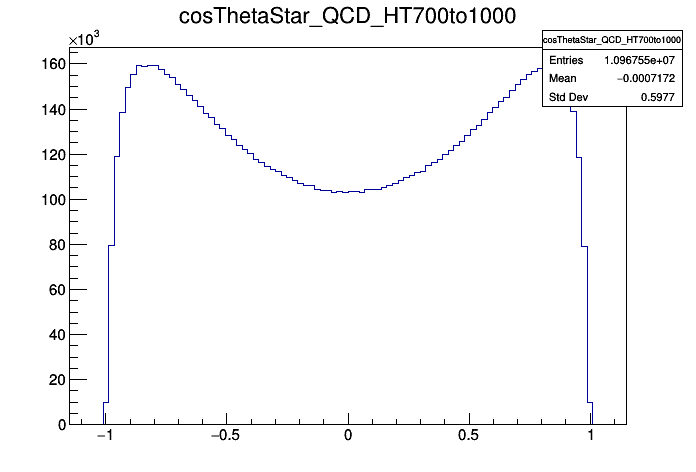

In [14]:
canvas = r.TCanvas()
hists[7].Draw()
canvas.Draw()